In [1]:
import HHBlits
import get_cullin_e3_ppi_from_pdb70
import cullin_benchmark_test
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from pathlib import Path
import scipy as sp
from Bio import SeqIO
import sys
import numpyro
import lpmf
import lpdf
from _search_producers import metropolis_hastings
import jax

# Helper functions

In [2]:
def sizeof(x):
    print("{:,}".format(sys.getsizeof(x)))
#NOTES
#The analysis doesn't include vif which it needs to run HHBlits for vif and other viral proteins
#There are a few hub pdbs (maybe visualize as a netowrk...) with many uids
#

#Load in some notebook globalsj
cullin_benchmark = cullin_benchmark_test.CullinBenchMark(
    dirpath=Path("../../data/raw/cullin_e3_ligase/"))

In [3]:
# add r1, r2, r3 and c1, ..., cn to dataframe
cullin_benchmark.parse_spec_counts(drop_spec_columns=True)

In [4]:
sizeof(cullin_benchmark.data)

2,042,393


In [ ]:

def f(x):
    k, mu = x
    return lpmf.poisson(k, mu)
    
def proposal(prng_key, k):
    mu = jax.random.uniform(prng_key)* 250
    x = k, mu
    return x


mh_init, mh_update, get_x = metropolis_hastings(f, proposal)
key = jax.random.PRNGKey(13)
search_state = mh_init


In [ ]:
proposal

In [5]:
?metropolis_hastings

In [18]:
?numpyro.distributions.Poisson

In [20]:
s = cullin_benchmark.data["r1"]
s = pd.to_numeric(s, downcast='integer')
cullin_benchmark.data["r1"] = s

In [22]:
cullin_benchmark.data["r1"]

0       22
1       11
2        8
3       77
4       19
        ..
6550     9
6551     0
6552     0
6553     0
6554     0
Name: r1, Length: 6555, dtype: int16

In [2]:
nb_globals = {}
nb_globals["n_bait"] = len(set(cullin_benchmark.data["Bait"]))
nb_globals["n_prey"] = len(set(cullin_benchmark.data["Prey"]))
nb_globals["n_failed"] = len(set(cullin_benchmark.failed))

# What is the distribution of sequence lengths in query uniprot ids?
# Because if the sequences are short it is likely to get many hits



suffix = "wt_MG132"
bait_elob = f"ELOB{suffix}"
bait_cbfb = f"CBFB{suffix}"
bait_cul5 = f"CUL5{suffix}"

In [3]:
pdb_uid_0dot9: dict = get_cullin_e3_ppi_from_pdb70.step4(prob_threshold=0.9, 
                                                         dev_path=True,
                                                         verbose=False)

# A particular uniprot id can "hit" the same pdb multiple times in HHBlits because there may be multiple
# chains within the complex
# Therefore it is important to distinguish the set of unique uniprot ids, meaning at least 1 chain was found

unique_pdb_uid_0dot9 = {key: set(val) for key, val in pdb_uid_0dot9.items()}

#for key, value in pdb_uid_0dot9.items():
    #assert len(set(value)) == len(value), f"{key} N-unique {len(set(value))}, N-total {len(value)}"
    
def get_n_uids_per_pdb(d):
    n_uids = {pdb_id: len(uids) for pdb_id, uids in d.items()}
    n_uniprot_ids_per_pdb_id = [val for _, val in n_uids.items()]
    n_uniprot_ids_per_pdb_id = sorted(n_uniprot_ids_per_pdb_id, reverse=True)
    return n_uniprot_ids_per_pdb_id

n_uniprot_ids_per_pdb_id = get_n_uids_per_pdb(pdb_uid_0dot9)
n_unique_uniprot_ids_per_pdb_id = get_n_uids_per_pdb(unique_pdb_uid_0dot9)

In [4]:
unique_prey_df = pd.DataFrame(columns=["Prey", "MaxSaintScore", "SeqLen", "N-pdb90"])
unique_prey_df["Prey"] = list(set(cullin_benchmark.data["Prey"]))

n_pdb_ids = {prey: 0 for prey in unique_prey_df["Prey"]}

assert len(set(unique_pdb_uid_0dot9.keys())) == len(unique_pdb_uid_0dot9.keys())

for pdb_id, uids in unique_pdb_uid_0dot9.items():
    for uid in uids:
        assert uid in n_pdb_ids
        val = n_pdb_ids[uid]
        val += 1
        n_pdb_ids[uid] = val
    
    
for i, prey in enumerate(unique_prey_df["Prey"]):
    max_saint = max(cullin_benchmark.data[cullin_benchmark.data["Prey"]==prey]["SaintScore"])
    unique_prey_df.loc[i, "MaxSaintScore"] = max_saint
    
    #Get the number of PDBs shared by a single prey
    
    if prey in n_pdb_ids:
        unique_prey_df.loc[i, "N-pdb90"] = n_pdb_ids[prey]
    


fasta = SeqIO.parse("../../data/interim/cullin_e3_ligase/prey.fasta", "fasta")
for i, seq in enumerate(fasta):
    seq_len = len(seq.seq)
    uid = seq.description.split("|")[1]
    
    assert sum(unique_prey_df["Prey"]==uid)==1, f"{i, uid}"
    unique_prey_df.loc[unique_prey_df["Prey"]==uid, "SeqLen"] = seq_len
    
    
    
def summarize_dict(d: dict):
    s  = (f"N-keys {len(d.keys())}")
    return s

Text(0, 0.5, 'Sequence Length')

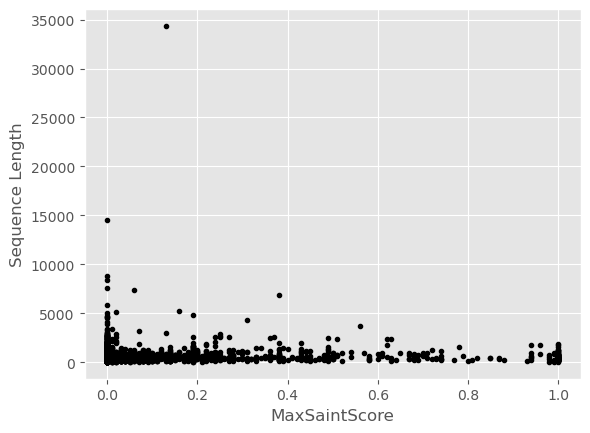

In [5]:
plt.style.use("ggplot")
plt.plot(unique_prey_df["MaxSaintScore"], unique_prey_df["SeqLen"], 'k.')
plt.xlabel("MaxSaintScore")
plt.ylabel("Sequence Length")

Text(0, 0.5, 'N-pdb90')

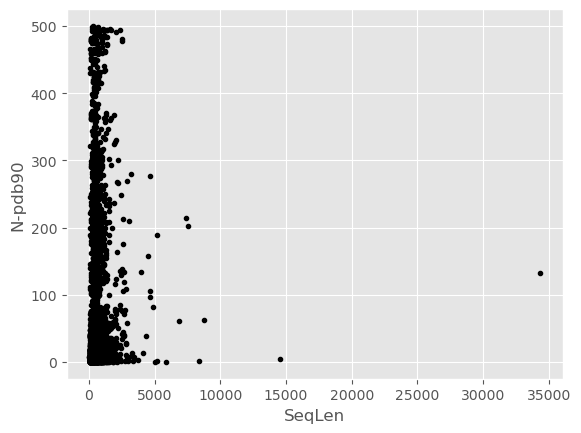

In [6]:
x = "N-pdb90"
y = "SeqLen"
t = x
x = y
y = t

# exluding very long sequences




plt.style.use("ggplot")
plt.plot(unique_prey_df[x], unique_prey_df[y], 'k.')
plt.xlabel(x)
plt.ylabel(y)

Text(0, 0.5, 'N-pdb90')

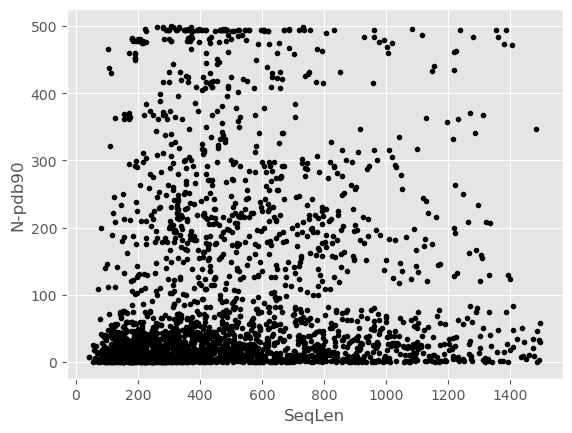

In [7]:
max_len = 1500
row_indexer = unique_prey_df["SeqLen"] < max_len
df = unique_prey_df[row_indexer]

plt.style.use("ggplot")
plt.plot(df[x], df[y], 'k.')
plt.xlabel(x)
plt.ylabel(y)

/home/aji/anaconda3/envs/pynet/lib/python3.11/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/aji/anaconda3/envs/pynet/lib/python3.11/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


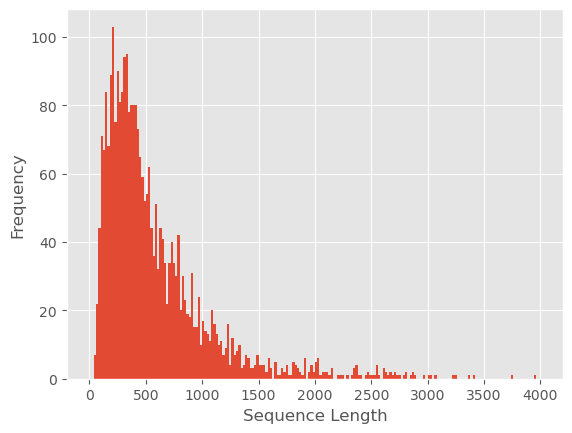

In [8]:
plt.hist(unique_prey_df["SeqLen"], bins=200, range=(0, 4000))
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

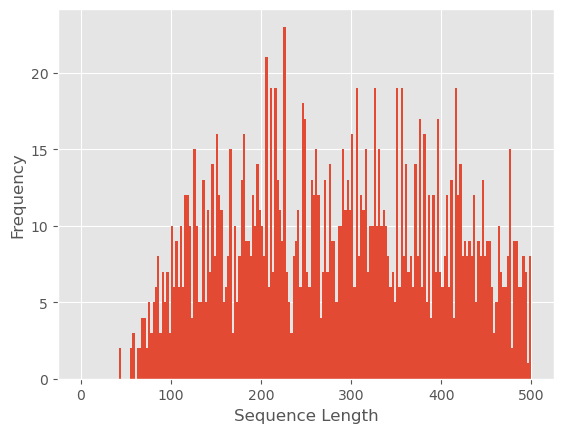

In [9]:
plt.hist(unique_prey_df["SeqLen"], bins=200, range=(0, 500))
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

Text(0, 0.5, 'MaxSaintScore')

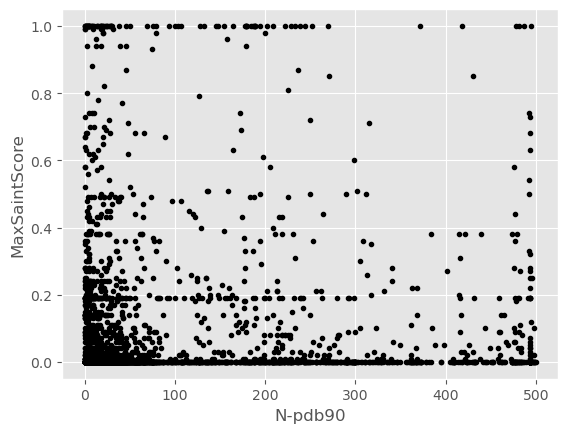

In [10]:
plt.style.use("ggplot")
plt.plot(unique_prey_df["N-pdb90"], unique_prey_df["MaxSaintScore"], 'k.')
plt.xlabel("N-pdb90")
plt.ylabel("MaxSaintScore")

In [11]:
row_indexer = unique_prey_df["SeqLen"] > 10000
unique_prey_df[row_indexer]

,Prey,MaxSaintScore,SeqLen,N-pdb90
148,Q8WXI7,0.0,14507,4
1613,Q8WZ42,0.13,34350,132


In [12]:
# Build a dataframe indexed by the pdb_id
pdb_id_df = pd.DataFrame(index = range(len(pdb_uid_0dot9)), 
                         columns=["pdb_id", "n-hits", "n-unique-hits"])


for i, t in enumerate(pdb_uid_0dot9.items()):
    pdb_id, uids = t
    n_hits = len(uids)
    n_unique_hits = len(set(uids))
    
    assert n_hits > 0, f"{i, pdb_id, n_hits}"
    assert n_unique_hits > 0
    pdb_id_df.loc[i, ["pdb_id", "n-hits", "n-unique-hits"]] = pdb_id, n_hits, n_unique_hits

In [13]:
pdb_id_df["n-hits"] = pd.to_numeric(pdb_id_df["n-hits"])
pdb_id_df["n-unique-hits"] = pd.to_numeric(pdb_id_df["n-unique-hits"])
    

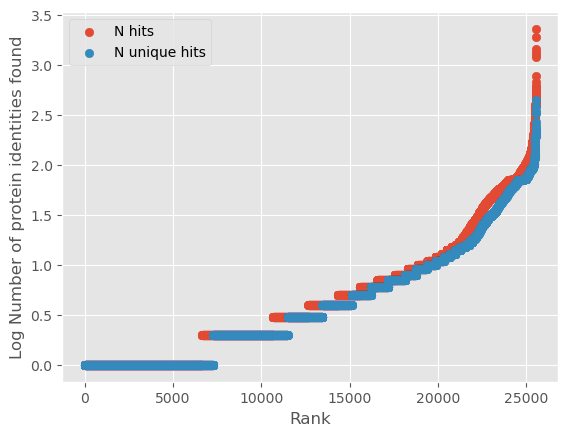

In [14]:
#alphas = [0.01]*len(n_unique_uniprot_ids_per_pdb_id)

start=1
stop=len(pdb_id_df) + 1
log = True
x = np.arange(start, stop)


y1 = sorted(pdb_id_df['n-unique-hits'])
y2 = sorted(pdb_id_df['n-hits'])

if log:
    y1 = np.log10(y1)
    y2 = np.log10(y2)
    

plt.style.use("ggplot")
plt.scatter(x, y2, label="N hits")
plt.scatter(x, y1, alpha=None, label="N unique hits")


plt.ylabel("Log Number of protein identities found")
plt.xlabel("Rank")
plt.legend()

In [15]:
pdb_id_df.sort_values("n-hits")

,pdb_id,n-hits,n-unique-hits
25561,3VX7,1,1
5501,6ECB,1,1
19392,1KCM,1,1
19393,4V67,1,1
19395,1J3A,1,1
...,...,...,...
575,3JB9,1253,332
607,6ID1,1346,376
566,7DCO,1439,441
563,6RXU,1889,247


In [16]:
#Lets create the NxN adjacency matrix
# Does not yet include vif!
N = len(unique_prey_df)
A = np.zeros((N, N))

prey_indicies = {prey: index for index, prey in enumerate(unique_prey_df["Prey"])}

In [17]:
# Fill in the weighted adjacency matrix
for pdb_id, uids in pdb_uid_0dot9.items():
    unique_uids = list(set(uids))
    l = len(unique_uids)
    if l > 1:
        for i in range(0, l):
            for j in range(i+1, l):
                assert i != j
                prey_u = unique_uids[i]
                prey_v = unique_uids[j]
                
                assert prey_u != prey_v
                
                index_u = prey_indicies[prey_u]
                index_v = prey_indicies[prey_v]
                
                assert index_u != index_v
                
                value = A[index_u, index_v]
                value = value + 1
                A[index_u, index_v] = value

In [19]:
# Why is it that a few PDB ids have many (1000s) of hits in them?

max(n_uniprot_ids_per_pdb_id)

2291

Text(0.5, 0, 'Rank')

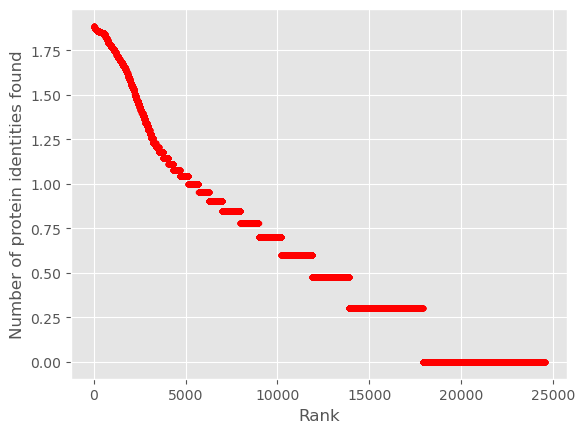

In [21]:
# Removing the top 100 solutions because it's weird to have 2000 hits per pdb_id
start = 0
stop = 1000
plt.style.use("ggplot")
plt.plot(np.arange(1, len(n_uniprot_ids_per_pdb_id[stop:-1]) + 1), np.log10(n_uniprot_ids_per_pdb_id[stop:-1]), 'r.')
plt.ylabel("Number of protein identities found")
plt.xlabel("Rank")

Text(0.5, 0, 'Rank')

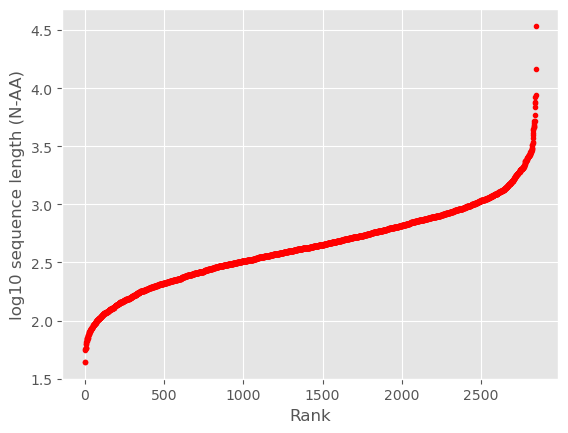

In [22]:
# What is the distribution of sequence lengths in query uniprot ids?
# Because if the sequences are short it is likely to get many hits

fasta = SeqIO.parse("../../data/interim/cullin_e3_ligase/prey.fasta", "fasta")
fasta_lengths = sorted([len(seq.seq) for seq in fasta])

plt.plot(np.arange(1, len(fasta_lengths) + 1), np.log10(np.array(fasta_lengths)), 'r.')
plt.ylabel("log10 sequence length (N-AA)")
plt.xlabel("Rank")

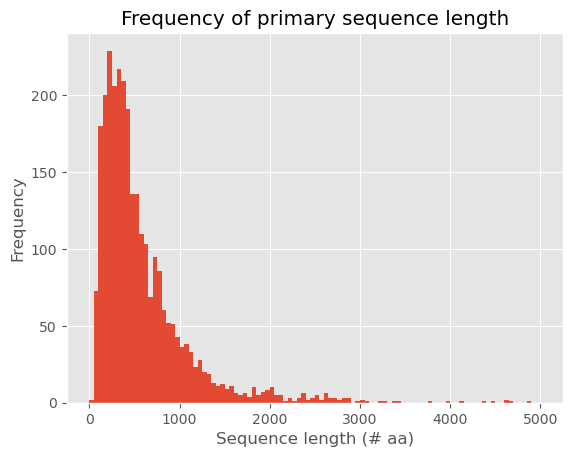

In [23]:
plt.hist(fasta_lengths, bins=100, range=(1, 5000))
plt.xlabel("Sequence length (# aa)")
plt.ylabel("Frequency")
plt.title("Frequency of primary sequence length")
plt.show()

In [24]:
# Filter out sequences less than the length of vif
# vif has the id P69723
vifprotein = "MENRWQVMIVWQVDRMRIRTWKSLVKHHMYVSGKARGWFYRHHYESPHPRISSEVHIPLGDARLVITTYWGLHTGERDWHLGQGVSIEWRKKRYSTQVDPELADQLIHLYYFDCFSDSAIRKALLGHIVSPRCEYQAGHNKVGSLQYLALAALITPKKIKPPLPSVTKLTEDRWNKPQKTKGHRGSHTMNGH"
fasta = SeqIO.parse("../../data/interim/cullin_e3_ligase/prey.fasta", "fasta")
for i, seq in enumerate(fasta):
    uid = seq.description.split("|")[1]
    if str(uid) == "P69723":
        vifseq = seq
    
    

In [28]:
cullin_benchmark.data.loc[0, 'r1'] = 0

In [31]:
cullin_benchmark.data

,Bait,Prey,PreyGene,Spec,SpecSum,AvgSpec,NumReplicates,ctrlCounts,AvgP,MaxP,TopoAvgP,TopoMaxP,SaintScore,FoldChange,BFDR,r1
0,CBFBwt_MG132,vifprotein,vifprotein,22|22|26|34,104,26.00,4,0|0|1|1|0|1|3|2|1|0|0|0,1.00,1.0,1.00,1.0,1.00,34.67,0.00,0.0
1,CBFBwt_MG132,Q9UBF6,RBX2_HUMAN,9|11|12|16,48,12.00,4,0|0|0|0|0|0|0|0|1|0|0|0,1.00,1.0,1.00,1.0,1.00,120.00,0.00,NaN
2,CBFBwt_MG132,Q9C0K0,BC11B_HUMAN,8|8|26|27,69,17.25,4,0|2|2|0|3|1|1|0|4|3|1|1,0.96,1.0,0.96,1.0,0.96,11.50,0.00,NaN
3,CBFBwt_MG132,Q93034,CUL5_HUMAN,78|77|66|99,320,80.00,4,0|0|0|0|0|0|0|1|0|0|1|0,1.00,1.0,1.00,1.0,1.00,480.00,0.00,NaN
4,CBFBwt_MG132,Q8TEB1,DCA11_HUMAN,24|19|15|11,69,17.25,4,0|0|0|0|0|1|3|0|1|0|1|0,1.00,1.0,1.00,1.0,1.00,34.50,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6550,ELOBwt_MG132,O00232,PSD12_HUMAN,10|9|12|12,43,10.75,4,12|10|11|17|17|19|19|15|7|11|16|11,0.00,0.0,0.00,0.0,0.00,0.78,0.92,NaN
6551,ELOBwt_MG132,O00139,KIF2A_HUMAN,0|0|0|0,0,0.00,4,0|0|1|0|1|0|3|4|0|0|0|0,0.00,0.0,0.00,0.0,0.00,0.00,0.92,NaN
6552,ELOBwt_MG132,A8MTZ0,BBIP1_HUMAN,1|0|1|1,3,0.75,4,0|0|0|0|0|0|0|0|0|0|0|0,0.00,0.0,0.00,0.0,0.00,7.50,0.92,NaN
6553,ELOBwt_MG132,A4UGR9,XIRP2_HUMAN,0|0|0|0,0,0.00,4,0|0|0|0|0|0|0|0|0|1|0|0,0.00,0.0,0.00,0.0,0.00,0.00,0.92,NaN
